## Прогнозирование цен на компьютерную технику

Данные взяты с сайта https://xmldatafeed.com/

In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

!pip freeze > requirements.txt

RANDOM_SEED = 42

In [2]:
# Взглянем на данные

df = pd.read_excel('xcomshop.xlsm')
df.sample(3)

,Артикул,Производитель,Название,Цена,Старая цена,Ссылка на товар,Ссылки на картинки,Дата последнего обновления,Описание,Каталог,Гарантия,Характеристики
21134,HCI-EN-CPU-C,VMware,Право на использование (электронно) VMware HCI...,1063919,1151270,https://www.xcom-shop.ru/vmware_hci_kit_6_ente...,NaN,2020-08-10 17:34:00,NaN,NaN,Гарантия на отсутствие дефектов на момент прод...,NaN
58525,Код товара: 544407,Konica Minolta,Опция Konica Minolta A3PGWY1,11884,0,https://www.xcom-shop.ru/konica_minolta_a3pgwy...,NaN,2020-08-10 21:40:00,Дуплекс AD-509 Konica-Minolta bizhub 215/226,NaN,Произведено: КИТАЙ,NaN
74616,Код товара: 673532,Opticin,Модуль DWDM SFP+ Opticin SFP-Plus-DWDM-1549.32-80,28350,46041,https://www.xcom-shop.ru/opticin_sfp-plus-dwdm...,NaN,2020-08-10 21:11:00,"1549.32нм, DDM, LC, 80km",NaN,Гарантия 12 мес. В сервисном центре компании X...,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93819 entries, 0 to 93818
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Артикул                     93819 non-null  object        
 1   Производитель               93726 non-null  object        
 2   Название                    93819 non-null  object        
 3   Цена                        93819 non-null  int64         
 4   Старая цена                 93819 non-null  int64         
 5   Ссылка на товар             93819 non-null  object        
 6   Ссылки на картинки          27271 non-null  object        
 7   Дата последнего обновления  93819 non-null  datetime64[ns]
 8   Описание                    83155 non-null  object        
 9   Каталог                     0 non-null      float64       
 10  Гарантия                    93819 non-null  object        
 11  Характеристики              0 non-null      float64   

In [4]:
df.nunique()

Артикул                       93808
Производитель                   806
Название                      84953
Цена                          32272
Старая цена                   14209
Ссылка на товар               93819
Ссылки на картинки            27258
Дата последнего обновления      232
Описание                      73562
Каталог                           0
Гарантия                        107
Характеристики                    0
dtype: int64

## Предобработка

In [3]:
# Нас интересуют компьютеры, оставим строки в названии которых есть это слово

df_2 = df[df['Название'].str.contains('Компьютер', na = False)]

In [4]:
# Также нам встречается "компьютерная акустика", уберем и ее

strings_drop = df_2[df_2['Название'].apply(lambda x: x.startswith('Компьютерная акустика'))].index
df_3 = df_2.drop(strings_drop)

In [7]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1288 to 90063
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Артикул                     2748 non-null   object        
 1   Производитель               2748 non-null   object        
 2   Название                    2748 non-null   object        
 3   Цена                        2748 non-null   int64         
 4   Старая цена                 2748 non-null   int64         
 5   Ссылка на товар             2748 non-null   object        
 6   Ссылки на картинки          2562 non-null   object        
 7   Дата последнего обновления  2748 non-null   datetime64[ns]
 8   Описание                    2748 non-null   object        
 9   Каталог                     0 non-null      float64       
 10  Гарантия                    2748 non-null   object        
 11  Характеристики              0 non-null      float64 

## Функции

In [5]:
# Функция переименования столбца "Гарантия"

def rename_guarantee(x):
    if x == 'Гарантия 12 мес. В сервисном центре производителяПри предъявлении документа о покупке':
        return 12
    elif x == 'Гарантия 12 мес. В сервисном центре производителяПри предъявлении гарантийного талона':
        return 12
    elif x == 'Гарантия 36 мес. В сервисном центре компании X-ComПри предъявлении документа о покупке':
        return 36
    elif x == 'Гарантия 36 мес. От производителя с выездом на место эксплуатации':
        return 36
    elif x == 'Гарантия 36 мес. В сервисном центре производителяПри предъявлении документа о покупке':
        return 36
    elif x == 'Гарантия 36 мес. В сервисном центре производителяПри предъявлении гарантийного талона':
        return 36
    elif x == 'Гарантия 12 мес. От производителя с выездом на место эксплуатации':
        return 12
    elif x == 'Гарантия 12 мес. В сервисном центре компании X-ComПри предъявлении документа о покупке':
        return 12
    elif x == 'Гарантия 24 мес. В сервисном центре производителяПри предъявлении гарантийного талона':
        return 24
    elif x == 'Гарантия 24 мес. В сервисном центре производителяПри предъявлении документа о покупке':
        return 24
    elif x == 'Гарантия 60 мес. В сервисном центре компании X-ComПри предъявлении документа о покупке':
        return 60
    elif x == 'Гарантия 1 мес. В сервисном центре компании X-ComПри предъявлении документа о покупке':
        return 1
    else:
        return 12


# Функция для замены значений

def multiple_map(target_str, map_values):
    target_str = target_str.map(map_values)
    return target_str

# Функция для расчета МАЕ

def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# EDA

In [10]:
# Проведем предварительный анализ с помощью Pandas profiling

profile = ProfileReport(df_3)
profile

Предварительный анализ показал: категориальных переменных 7, числовых - 3, дата - 1. Два столбца полностью нулевые. Отсутствие дубликатов строк. Наличие пропущенных значений - 15.9%. Отсутствие какой-либо значимой корреляции между столбцами.

Столбцы: Артикул, Старая цена, Название, Ссылка на товар, Ссылки на картинки, Дата последнего обновления - не несут какой-либо значимой информации; Каталог, Характеристики - содержат только нули.

In [6]:
# Удалим ненужные столбцы

col_drop = ['Артикул', 'Старая цена', 'Ссылка на товар', 'Ссылки на картинки',
    'Дата последнего обновления', 'Каталог', 'Характеристики', 'Название']

df_3.drop(col_drop, axis=1, inplace=True)

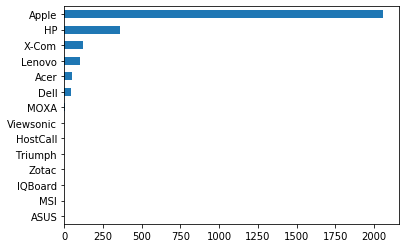

In [10]:
df_3['Производитель'].value_counts(ascending=True).plot(kind='barh')

In [11]:
df_3['Производитель'].value_counts()

Apple        2058
HP            362
X-Com         123
Lenovo         99
Acer           51
Dell           43
MOXA            5
ASUS            1
MSI             1
IQBoard         1
Zotac           1
Triumph         1
HostCall        1
Viewsonic       1
Name: Производитель, dtype: int64

In [7]:
# Удалим производителей с небольшим количеством моделей 

df_4 = df_3[df_3['Производитель'].isin(['Apple', 'HP', 'X-Com', 'Lenovo', 'Acer', 'Dell'])]

In [8]:
# Сбросим индексы

df_4 = df_4.reset_index(drop=True)

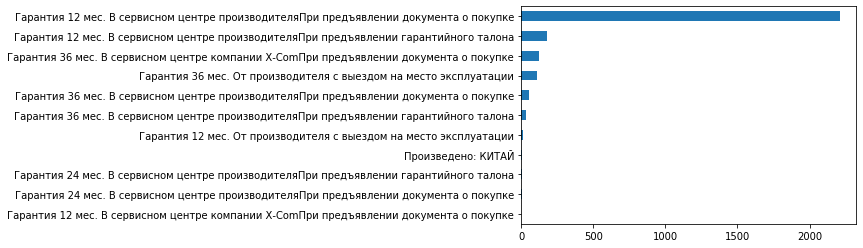

In [14]:
df_4['Гарантия'].value_counts(ascending=True).plot(kind='barh')

In [9]:
# Применим функцию переименования и оставим в столбце "Гарантия" только числовые значения

df_4['Гарантия'] = df_4['Гарантия'].apply(rename_guarantee)

In [16]:
df_4['Гарантия'].value_counts()

12    2411
36     319
24       6
Name: Гарантия, dtype: int64

In [17]:
df_4['Описание'].unique()

array(['i5-8500T, 16GB, 256GB SSD, UHD Graphics 630, NoODD, WiFi, BT, USB kbd/mouse, 65W, Win10Pro, black',
       'i3-8100T/4GB/500GB/UHD Graphics 630/NoODD/USB KB+Mouse/Win10Pro',
       'i5 8400T/8GB/1TB/noOS/WiFi/BT/клавиатура/мышь/черный', ...,
       '3.0-4.1GHz 6?core i5/32GB DDR4/2TB SSD/UHD Graphics 630/Space Gray',
       '3.0-4.1GHz 6?core i5/64GB DDR4/512GB SSD/UHD Graphics 630/Space Gray',
       '3.0-4.1GHz 6?core i5/16GB DDR4/512GB SSD/UHD Graphics 630/Space Gray'],
      dtype=object)

## Обработка и подготовка данных к моделированию 

In [10]:
# Обработаем столбец "Описание"

df_4['Описание'] = df_4['Описание'].astype(str).apply(lambda x: None if x.strip() == '' else x)
df_4['Описание'] = df_4['Описание'].apply(lambda x: x.replace("/", ', ').replace("?", ' ').replace("-", ' '))

In [11]:
# Разделим столбец "Описание", удалим ненужные столбцы и переименуем оставшиеся

df_5 = pd.DataFrame(df_4['Описание'].str.split(',').values.tolist())
df_5.drop(df_5.columns[[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]], axis=1, inplace=True)
df_5.columns=['Процессор','Оперативная память','Жесткий диск', 'Видеокарта']

In [12]:
# Соеденим получившиеся фреймы и удалим столбец "Описание"

data = pd.concat([df_4, df_5],axis=1).drop('Описание',axis=1) 
data.head(4)

,Производитель,Цена,Гарантия,Процессор,Оперативная память,Жесткий диск,Видеокарта
0,Lenovo,75950,36,i5 8500T,16GB,256GB SSD,UHD Graphics 630
1,Lenovo,44138,12,i3 8100T,4GB,500GB,UHD Graphics 630
2,Lenovo,40957,36,i5 8400T,8GB,1TB,noOS
3,Lenovo,32209,36,g5400T,4GB,1TB,NoDVD


In [21]:
data['Видеокарта'].value_counts().loc[lambda x : x > 5]

 Two Radeon Pro Vega II 32GB of HBM2 memory each               400
 Two Radeon Pro Vega II Duo with 2x32GB of HBM2 memory each    400
 Radeon Pro Vega II Duo with 2x32GB HBM2                       240
 Radeon Pro Vega II with 32GB HBM2                             240
 Radeon Pro 580X with 8GB GDDR5                                232
 Radeon Pro 580X 8GB                                           169
 Radeon Pro Vega II 32GB                                       160
 Radeon Pro Vega II Duo 2x32GB                                 160
 UHD Graphics 630                                              101
 Win10Pro                                                       68
 DVDRW                                                          43
 DVD WR                                                         33
 WiFi                                                           32
 DVD                                                            21
 noDVD                                                        

In [22]:
data['Видеокарта'].unique()

array([' UHD Graphics 630', ' noOS', ' NoDVD', ' noDVD', ' UHDG 610',
       ' oDVD', ' R2', ' HDG', ' UHD Graphics 605', ' UHDG 605',
       ' UHDG 600', ' DVD нет', ' WiFi+BT', ' Radeon RX Vega 11',
       ' Intel HD', ' HD', ' UHDG 620', ' UHD Graphics 610', ' Vega 11',
       ' Intel 9560', ' UHD Graphics 620', ' Integrated Graphics',
       ' 256GB SSD M.2', ' UHD 630', ' UHDG 630', ' 5" SATA', ' DVD±RW',
       ' DVDRW', ' DVD', ' GT 1030 2GB', ' RGr', ' GTX1650 4GB',
       'WiFi+BT', ' 1TB', ' DVD RW', ' DVD ODD',
       ' INTEGRATED GRAPHIC CARD', ' Win10Pro', ' WiFi', ' UHD',
       ' Quadro P620 2GB', ' Quadro P1000 4GB', ' Intel UHD 630 SD',
       ' Intel UHD 630 TPM', ' UHD 630 MCR', ' 256GB SSD', ' 120GB SSD',
       ' HD Graphics 630', ' DVDrw', ' USBkbd+mouse', ' DVD WR',
       ' Platinum 250W', ' Radeon RX 560 4GB', ' клавиатура', ' BT',
       ' HD G620', ' 500GB HDD', 'USBkbd+mouse', ' USB Kbd',
       ' Win10Pro + Spec', ' Slim usb kbd+mouse', ' No ODD',
       ' 

In [13]:
# Создадим словарь для переименования значений в столбце "Видеокарта"
# Все значения, не относящиеся к видеокартам заменим на встроенную видеокарту UHD Graphics 630 
# т.к. какая-либо видеокарта все равно должна быть

map_values = {
    ' UHD Graphics 630':'UHD Graphics 630', ' noOS':'UHD Graphics 630', ' NoDVD':'UHD Graphics 630', 
    ' noDVD':'UHD Graphics 630', ' UHDG 610':'UHD Graphics 630', ' oDVD':'UHD Graphics 630', 
    ' R2':'UHD Graphics 630',     ' HDG':'UHD Graphics 630', ' UHD Graphics 605':'UHD Graphics 605', 
    ' UHDG 605':'UHD Graphics 605', ' UHDG 600':'UHD Graphics 600', ' DVD нет':'UHD Graphics 630', 
    ' WiFi+BT':'UHD Graphics 630', ' Radeon RX Vega 11':'Radeon RX Vega 11', ' Intel HD':'UHD Graphics 630', 
    ' HD':'UHD Graphics 630', ' UHDG 620':'UHD Graphics 620', ' UHD Graphics 610':'UHD Graphics 610', 
    ' Vega 11':'Radeon RX Vega 11', ' Intel 9560':'UHD Graphics 630', ' UHD Graphics 620':'UHD Graphics 620', 
    ' Integrated Graphics':'UHD Graphics 630', ' 256GB SSD M.2':'UHD Graphics 630', ' UHD 630':'UHD Graphics 630', 
    ' UHDG 630':'UHD Graphics 630', ' 5" SATA':'UHD Graphics 630', ' DVD±RW':'UHD Graphics 630',
    ' DVDRW':'UHD Graphics 630', ' DVD':'UHD Graphics 630', ' GT 1030 2GB':'GeForce GT 1030 2GB', 
    ' RGr':'UHD Graphics 630', ' GTX1650 4GB':'GeForce GTX 1650 4GB', 'WiFi+BT':'UHD Graphics 630', 
    ' 1TB':'UHD Graphics 630', ' DVD RW':'UHD Graphics 630', ' DVD ODD':'UHD Graphics 630',
    ' INTEGRATED GRAPHIC CARD':'UHD Graphics 630', ' Win10Pro':'UHD Graphics 630', ' WiFi':'UHD Graphics 630', 
    ' UHD':'UHD Graphics 630', ' Quadro P620 2GB':'Quadro P620 2GB', ' Quadro P1000 4GB':'Quadro P1000 4GB', 
    ' Intel UHD 630 SD':'UHD Graphics 630', ' Intel UHD 630 TPM':'UHD Graphics 630', 
    ' UHD 630 MCR':'UHD Graphics 630', ' 256GB SSD':'UHD Graphics 630', ' 120GB SSD':'UHD Graphics 630',
    ' HD Graphics 630':'UHD Graphics 630', ' DVDrw':'UHD Graphics 630', ' USBkbd+mouse':'UHD Graphics 630', 
    ' DVD WR':'UHD Graphics 630', ' Platinum 250W':'UHD Graphics 630', ' Radeon RX 560 4GB':'Radeon RX 560 4GB', 
    ' клавиатура':'UHD Graphics 630', ' BT':'UHD Graphics 630', ' HD G620':'UHD Graphics 630', 
    ' 500GB HDD':'UHD Graphics 630', 'USBkbd+mouse':'UHD Graphics 630', ' USB Kbd':'UHD Graphics 630',
    ' Win10Pro + Spec':'UHD Graphics 630', ' Slim usb kbd+mouse':'UHD Graphics 630', ' No ODD':'UHD Graphics 630',
    ' Realtek RTL8821CE AC 1x1 BT':'UHD Graphics 630', ' Win10Pro + HP Monitor N246v':'UHD Graphics 630',
    ' 1TB HDD':'UHD Graphics 630', ' Win10Home':'UHD Graphics 630', ' USB kbd+m':'UHD Graphics 630', 
    ' USB Slim kbd+mouse':'UHD Graphics 630', ' USB Slim kbd+mouseUSB':'UHD Graphics 630', 
    ' UHD 630 TPM':'UHD Graphics 630', ' Radeon RX 550 4GB':'Radeon RX 550 4GB', 
    ' RTX 2080 8GB':'GeForce RTX 2080 8GB', ' Intel UHD 630':'UHD Graphics 630', ' Linux':'UHD Graphics 630', 
    ' 2TB':'UHD Graphics 630', ' DVD rw':'UHD Graphics 630', ' USB kbd':'UHD Graphics 630', 
    ' Stand':'UHD Graphics 630', ' USB Slim kbd':'UHD Graphics 630', ' GeForce RTX2060 6GB':'GeForce RTX 2060 6GB',
    'DVDRW':'UHD Graphics 630', ' GeForce GT730 2GB':'GeForce GT 730 2GB', 
    ' GeForce GT730 2GB GDDR5':'GeForce GT 730 2GB', ' R7 430 64bit':'UHD Graphics 630', 
    ' DOS':'UHD Graphics 630', ' Graphics 600':'UHD Graphics 600', ' AMD integrated graphics':'UHD Graphics 630', 
    ' Radeon RX 550 2GB DDR5':'Radeon RX 550 2GB', ' Radeon RX 5300XT 4GB':'Radeon RX 5300 XT 4GB', 
    ' Graphics':'UHD Graphics 600', ' GT1030 2GB':'GeForce GT 1030 2GB', ' Graphics 630':'UHD Graphics 630', 
    ' Radeon Vega 11':'Radeon RX Vega 11', ' Free DOS':'UHD Graphics 630', ' 512GB SSD':'UHD Graphics 630',
    ' GeForce RTX 2080 8GB GDDR6':'GeForce RTX 2080 8GB', ' RTX 2060 6GB GDDR6':'GeForce RTX 2060 6GB', 
    ' SSD 240GB':'UHD Graphics 630', ' SSD NVMe 250GB + 2TB':'UHD Graphics 630', 
    ' Optane 280GB + 2TB':'UHD Graphics 630', ' Optane 480GB + 2TB':'UHD Graphics 630', 
    ' 480GB SSD':'UHD Graphics 630', ' 240GB SSD':'UHD Graphics 630', ' 500GB':'UHD Graphics 630',
    ' 240Gb SSD':'UHD Graphics 630', ' 128GB SSD':'UHD Graphics 630', ' 256GB SSD ':'UHD Graphics 630', 
    ' 1TB SSD':'UHD Graphics 630', ' Quadro P2000 5GB':'Quadro P2000 5GB', 
    ' Intel UHD Graphics 630':'UHD Graphics 630', ' UHD Graphics 600':'UHD Graphics 630', 
    ' SSD NVMe 512GB + 2TB':'UHD Graphics 630', ' 256Gb SSD':'UHD Graphics 630', ' SSD 64GB':'UHD Graphics 630', 
    ' NVMe SSD 1TB':'UHD Graphics 630', ' NVMe SSD Intel Optane 960GB':'UHD Graphics 630',
    ' 240Gb SSD + 1TB HDD':'UHD Graphics 630', ' 480Gb SSD + 1TB HDD':'UHD Graphics 630',
    ' 500Gb NVMe SSD + 2TB HDD':'UHD Graphics 630', ' SSD NVMe 250GB + 1TB':'UHD Graphics 630', 
    ' SSD 480GB':'UHD Graphics 630', ' SSD 240GB + 1TB':'UHD Graphics 630', ' SSD 480GB + 2TB':'UHD Graphics 630', 
    ' SSD 960GB':'UHD Graphics 630', ' SSD 960GB + 2TB':'UHD Graphics 630', 
    ' 250GB NVMe SSD + 1TB':'UHD Graphics 630', ' 128GB NVMe SSD + 1TB HDD':'UHD Graphics 630', 
    ' SSD NVMe 500GB + 2TB':'UHD Graphics 630', ' Radeon Pro 580X 8GB':'Radeon Pro 580X 8GB', 
    ' Radeon Pro Vega II 32GB':'Radeon Pro Vega II 32GB', 
    ' Two Radeon Pro Vega II 32GB of HBM2 memory each':'Radeon Pro Vega II 32GB',
    ' Radeon Pro Vega II Duo 2x32GB':'Radeon Pro Vega II Duo 2x32GB',
    ' Two Radeon Pro Vega II Duo with 2x32GB of HBM2 memory each':'Radeon Pro Vega II Duo 2x32GB',
    ' Radeon Pro 580X with 8GB GDDR5':'Radeon Pro 580X 8GB',
    ' Radeon Pro Vega II with 32GB HBM2':'Radeon Pro Vega II 32GB',
    ' Radeon Pro Vega II Duo with 2x32GB HBM2':'Radeon Pro Vega II Duo 2x32GB',
    ' Two Radeon Pro Vega II 32GB HBM2':'Radeon Pro Vega II 32GB'
}

In [14]:
# Применим функцию переименования значений для столбца "Видеокарта"

data['Видеокарта'] = multiple_map(data['Видеокарта'], map_values)

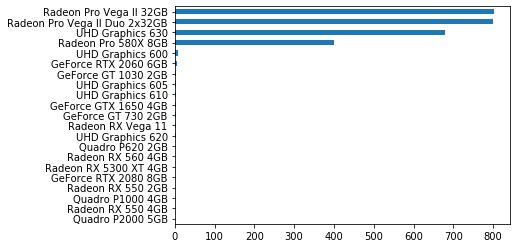

In [25]:
data['Видеокарта'].value_counts(ascending=True).plot(kind='barh')

In [26]:
data['Жесткий диск'].unique()

array([' 256GB SSD', ' 500GB', ' 1TB', ' 128GB SSD', ' 256GB',
       ' 1TB 5400rpm', ' SSD256GB', ' noDVD', ' 256GB SSD M.2', ' 1TB HD',
       ' 256GB SSD 2', ' 256G SSD', ' SSD 256GB', ' 256 GB SSD',
       ' 1TB SSD', ' 256GB M.2', ' 512GB SSD', '1Tb 7200', ' 1TB SATA',
       ' 1TB 7.2k', ' 1 x 256GB SSD', ' 4GB DDR4', ' 1TB 7200',
       ' 1TB HDD', ' 256GB M.2 PCIe', ' 512GB M.2 2280 PCIe',
       ' 256GB M.2 2280 PCIe NVMe', ' 256GBSSD', ' 1000GB', ' 8GB',
       '500GB', ' 256GB SSD + 1TB', ' DVDrw', ' 16GB Optane +1TB',
       ' SSD 128GB M.2', ' 256PCISSDGB', ' BT', ' 128GB PCIe NVMe Value',
       ' 4GB', ' 256GBTLC', ' 500GB 7.2k', ' 128GB', ' 512GB',
       ' Intel UHD 630', ' Optane 16GB', ' SSD512GB', ' 256GB PCI SSD',
       '512GB SSD', ' 1Tb', ' 16GB', ' 128GB PCI SSD', ' 128GB PCIe TLC',
       ' 1Tb SSD', ' 16GB Memory', ' Intel Optane 16GB+1TB',
       ' 256GB M.2 PCIe NVMe', ' 512GB M.2 PCIe NVMe',
       ' 128GB M.2 2280 PCIe NVMe', ' 512GB Memory H10',
       '

In [27]:
data['Жесткий диск'].value_counts()

 256GB SSD             555
 1TB SSD               420
 2TB SSD               415
 8TB SSD               397
 4TB SSD               395
                      ... 
 1 x 256GB SSD           1
 128GB M.2 PCIe TLC      1
 500GB HDD               1
 1TB+256GB SSD           1
 5TB SSD                 1
Name: Жесткий диск, Length: 93, dtype: int64

In [15]:
# Создадим словарь для переименования значений в столбце "Жесткий диск"
# Все значения, не относящиеся к размеру жесткого диска заменим размер на 500GB 
# т.к. жесткий диск все равно должен быть и у него есть какой-то, хотя бы, минимальный размер

map_values = {
    ' 256GB SSD':'256GB SSD', ' 500GB':'500GB', ' 1TB':'1TB', ' 128GB SSD':'128GB SSD', ' 256GB':'256GB SSD',
    ' 1TB 5400rpm':'1TB', ' SSD256GB':'256GB SSD', ' noDVD':'500GB', ' 256GB SSD M.2':'256GB SSD', ' 1TB HD':'1TB',
    ' 256GB SSD 2':'256GB SSD', ' 256G SSD':'256GB SSD', ' SSD 256GB':'256GB SSD', ' 256 GB SSD':'256GB SSD',
    ' 1TB SSD':'1TB SSD', ' 256GB M.2':'256GB SSD', ' 512GB SSD':'512GB SSD', '1Tb 7200':'1TB', ' 1TB SATA':'1TB',
    ' 1TB 7.2k':'1TB', ' 1 x 256GB SSD':'256GB SSD', ' 4GB DDR4':'500GB', ' 1TB 7200':'1TB',
    ' 1TB HDD':'1TB', ' 256GB M.2 PCIe':'256GB SSD', ' 512GB M.2 2280 PCIe':'512GB SSD',
    ' 256GB M.2 2280 PCIe NVMe':'256GB SSD', ' 256GBSSD':'256GB SSD', ' 1000GB':'1TB', ' 8GB':'500GB',
    '500GB':'500GB', ' 256GB SSD + 1TB':'1TB', ' DVDrw':'500GB', ' 16GB Optane +1TB':'1TB',
    ' SSD 128GB M.2':'128GB SSD', ' 256PCISSDGB':'256GB SSD', ' BT':'500GB', ' 128GB PCIe NVMe Value':'128GB SSD',
    ' 4GB':'500GB', ' 256GBTLC':'256GB SSD', ' 500GB 7.2k':'500GB', ' 128GB':'500GB', ' 512GB':'500GB',
    ' Intel UHD 630':'500GB', ' Optane 16GB':'500GB', ' SSD512GB':'512GB SSD', ' 256GB PCI SSD':'256GB SSD',
    '512GB SSD':'512GB SSD', ' 1Tb':'1TB', ' 16GB':'500GB', ' 128GB PCI SSD':'128GB SSD', ' 128GB PCIe TLC':'128GB SSD',
    ' 1Tb SSD':'1TB SSD', ' 16GB Memory':'500GB', ' Intel Optane 16GB+1TB':'1TB',
    ' 256GB M.2 PCIe NVMe':'256GB SSD', ' 512GB M.2 PCIe NVMe':'512GB SSD',
    ' 128GB M.2 2280 PCIe NVMe':'128GB SSD', ' 512GB Memory H10':'512GB SSD',
    ' 256GB Memory H10':'256GB SSD', ' 128GB M.2 PCIe TLC':'128GB SSD', ' 500GB HDD':'500GB',
    ' 1TB+256GB SSD':'1TB', ' 128GB M.2':'128GB SSD', ' 512GB SSD+2TB':'2TB',
    ' 128GB 2280 PCIe 3x2 TLC':'128GB SSD', ' 128GB PCIe 3x2 TLC':'128GB SSD', ' 8GB DDR4':'500GB',
    ' 16GB DDR4':'500GB', ' 32GB DDR4':'500GB', ' 2TB 7.2k':'2TB', ' 2TB':'2TB', ' SSD128GB':'128GB SSD',
    ' 1ТB':'1TB', ' 256GB M.2 SSD':'256GB SSD', ' 500Gb':'500GB', ' 4GB DDR3':'500GB', ' 64GB DDR4':'500GB',
    ' 2TB SSD':'2TB SSD', ' 4TB SSD':'4TB SSD', ' 4TBB SSD':'4TB SSD', ' 2TBSSD':'2TB SSD', ' 1TBB SSD':'1TB SSD',
    ' 4TBSSD':'4TB SSD', ' 1TBGB SSD':'1TB SSD', ' 4TB6GB SSD':'1TB SSD', ' 8TB SSD':'8TB SSD', ' 1TB GB SSD':'1TB SSD',
    ' 1TB 6GB SSD':'1TB SSD', ' 4TB GB SSD':'4TB SSD', ' 6TB SSD':'6TB SSD', ' 8TB GB SSD':'8TB SSD', ' 5TB SSD':'5TB SSD' 
}

In [16]:
# Применим функцию переименования значений для столбца "Жесткий диск"

data['Жесткий диск'] = multiple_map(data['Жесткий диск'], map_values)

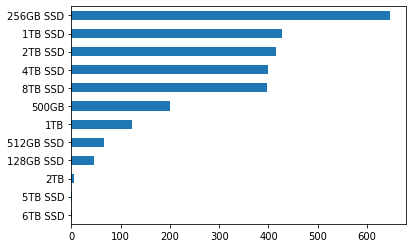

In [30]:
data['Жесткий диск'].value_counts(ascending=True).plot(kind='barh')

In [31]:
data['Оперативная память'].unique()

array([' 16GB', ' 4GB', ' 8GB', ' 256GB SSD', ' 8GB 512GB SSD',
       '8Gb DDR4 2666(1)', ' 32GB (2x16GB) DDR4 2666 ECC Reg',
       ' 32GB (4x8GB) DDR4 2666 ECC Reg', ' 1 x 8GB 2666 NON ECC UDIMM',
       ' 8GB ECC UDIMM', ' 16GB (2x8GB)', ' 16GB(2x8GB)', ' H110',
       ' 8GB DDR4 2666', ' 6GB DDR4 2666', ' 4GB DDR4', '4GB', ' 260 DM',
       ' 8GB DDR4 2400', ' 4GB DDR4 2400', ' 128PCISSDGB', ' 256PCISSDGB',
       ' 4GB DDR4 2666', ' 16GB DDR4', ' 8GB DDR4', '16GB DDR4 2666(1)',
       ' 32GB', ' H310', ' Z390', ' H370', ' A320', ' H410', ' 64GB',
       ' 128GB Win10Pro', ' 2GB', ' 500GB +128GB Win10Pro', ' 1TB LINUX',
       ' X470', ' SoC', ' SOC', ' B360', ' X570', ' X299', ' X399',
       ' B365', ' B450', ' B460', ' Z490', ' 32GB (4x8GB) DDR4',
       ' 96GB (6x16GB) DDR4', ' 48GB (6x8GB) DDR4',
       ' 192GB (6x32GB) DDR4', ' 384GB (6x64GB) DDR4',
       ' 768GB (6x128GB) DDR4', ' 768GB (12x64GB) DDR4',
       ' 1.5TB (12x128GB) DDR4', ' 48GB (6x8GB DDR4', ' 96 (6х16GB) DD

In [32]:
data['Оперативная память'].value_counts()

 8GB                                280
 192GB (6x32GB) DDR4                251
 32GB (4x8GB) DDR4                  251
 1.5TB (12x128GB) DDR4              250
 768GB (12x64GB) DDR4               250
 768GB (6x128GB) DDR4               250
 384GB (6x64GB) DDR4                250
 96GB (6x16GB) DDR4                 249
 48GB (6x8GB) DDR4                  249
 4GB                                156
 16GB                                52
 H310                                42
 16GB DDR4                           26
 8GB DDR4                            25
 B450                                17
 Z390                                17
 32GB DDR4                           14
 64GB DDR4                           14
 32GB                                11
 H410                                11
 B360                                10
 A320                                 7
 4GB DDR4                             5
 X570                                 4
 B365                                 4


In [17]:
# Создадим словарь для переименования значений в столбце "Оперативная память"
# Все значения, не относящиеся к размеру оперативной памяти заменим размер на 4GB 
# т.к. оперативная память все равно должна быть и у нее есть какой-то, хотя бы, минимальный размер

map_values = {
    ' 16GB':'16GB', ' 4GB':'4GB', ' 8GB':'8GB', ' 256GB SSD':'4GB', ' 8GB 512GB SSD':'8GB',
    '8Gb DDR4 2666(1)':'8GB', ' 32GB (2x16GB) DDR4 2666 ECC Reg':'32GB',
    ' 32GB (4x8GB) DDR4 2666 ECC Reg':'32GB', ' 1 x 8GB 2666 NON ECC UDIMM':'8GB',
    ' 8GB ECC UDIMM':'8GB', ' 16GB (2x8GB)':'16GB', ' 16GB(2x8GB)':'16GB', ' H110':'4GB',
    ' 8GB DDR4 2666':'8GB', ' 6GB DDR4 2666':'6GB', ' 4GB DDR4':'4GB', '4GB':'4GB', ' 260 DM':'4GB',
    ' 8GB DDR4 2400':'8GB', ' 4GB DDR4 2400':'4GB', ' 128PCISSDGB':'4GB', ' 256PCISSDGB':'4GB',
    ' 4GB DDR4 2666':'4GB', ' 16GB DDR4':'16GB', ' 8GB DDR4':'4GB', '16GB DDR4 2666(1)':'16GB',
    ' 32GB':'32GB', ' H310':'4GB', ' Z390':'4GB', ' H370':'4GB', ' A320':'4GB', ' H410':'4GB', ' 64GB':'64GB',
    ' 128GB Win10Pro':'128GB', ' 2GB':'2GB', ' 500GB +128GB Win10Pro':'128GB', ' 1TB LINUX':'4GB',
    ' X470':'4GB', ' SoC':'4GB', ' SOC':'4GB', ' B360':'4GB', ' X570':'4GB', ' X299':'4GB', ' X399':'4GB',
    ' B365':'4GB', ' B450':'4GB', ' B460':'4GB', ' Z490':'4GB', ' 32GB (4x8GB) DDR4':'32GB',
    ' 96GB (6x16GB) DDR4':'96GB', ' 48GB (6x8GB) DDR4':'48GB',
    ' 192GB (6x32GB) DDR4':'192GB', ' 384GB (6x64GB) DDR4':'384GB',
    ' 768GB (6x128GB) DDR4':'768GB', ' 768GB (12x64GB) DDR4':'768GB',
    ' 1.5TB (12x128GB) DDR4':'1.5TB', ' 48GB (6x8GB DDR4':'48GB', ' 96 (6х16GB) DDR4':'96GB',
    ' 32GB DDR4':'32GB', ' 64GB DDR4':'64GB'
}

In [18]:
# Применим функцию переименования значений для столбца "Оперативная память"

data['Оперативная память'] = multiple_map(data['Оперативная память'], map_values)

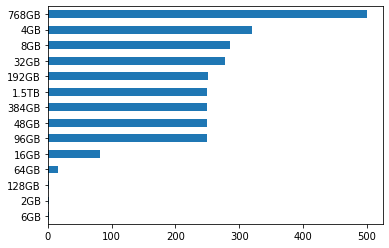

In [35]:
data['Оперативная память'].value_counts(ascending=True).plot(kind='barh')

In [36]:
data['Процессор'].unique()

array(['i5 8500T', 'i3 8100T', 'i5 8400T', 'g5400T', 'G5420T', 'i5 9400T',
       'i3 9100T', 'E2 9000e', 'J5005', 'j4005', 'PMD J5005', 'J4005',
       'i3 9100', 'i7 9700', 'Ryzen 3 2200GE', 'Ryzen R3 2200GE',
       'Ryzen 5 PRO 2400GE', 'i3 8145U', 'I3 8145U', '5405U', 'i5 8265U',
       'Ryzen 5 PRO 3400G', 'i3 8145U 8GB', '4205', 'G5420',
       'I5 9400 2.9G 6C', 'i5 9400', 'Ryzen 3 3250U', 'Ryzen 5 3500U',
       'i5 10500', 'i3 10100', '6400', '3050U', 'i5 9500',
       'HP ProDesk 600 G5 Mini Core i3 9100T 3.1GHz', 'i3 6100',
       'Xeon 4108', 'i5 9500T', 'i3 9100 ', 'i7 8700 3.2G 6C', 'i7 8700',
       'I5 9500', 'E 2224G', 'i5 10600K', 'Intel Pentium G4600',
       'i5 7500T', 'i3 8100', 'i7 8700T', 'R3 Pro 2200G', 'R5 Pro 2400G',
       'i5 8500T1', 'A10 9700E Pro', 'i3 7130U', 'i5 8500', '4415U',
       'i3 7130', 'i5 7200U', 'i3 6100T', 'i7 9700T', 'i3 8100 4GB',
       'i3 7130U 4GB', 'Ryzen3 Pro 2200G', 'Celeron 3865U', 'i5 8400H',
       'R5 Pro 2400GE', 'R3 Pro 220

In [37]:
data['Процессор'].value_counts()

3.5GHz 8 core Intel Xeon W     401
3.3GHz 12 core Intel Xeon W    400
2.7GHz 24 core Intel Xeon W    400
2.5GHz 28 core Intel Xeon W    400
3.2GHz 16 core Intel Xeon W    369
                              ... 
CI5 8500T 8                      1
Intel Pentium G4600              1
CMD J4005                        1
Cold5400                         1
J4005 2C                         1
Name: Процессор, Length: 169, dtype: int64

In [19]:
# Создадим словарь для переименования значений в столбце "Процессор"
# все значения, не относящиеся к типу процессора заменим на  самый часто встречающийся

map_values = {
    'i5 8500T':'i5 8500T', 'i3 8100T':'i3 8100T', 'i5 8400T':'i5 8400T', 'g5400T':'G5400T', 'G5420T':'G5420T', 'i5 9400T':'i5 9400T',
    'i3 9100T':'i3 9100T', 'E2 9000e':'E2-9000e', 'J5005':'J5005', 'j4005':'J4005', 'PMD J5005':'J5005', 'J4005':'J4005',
    'i3 9100':'i3 9100T', 'i7 9700':'i7 9700T', 'Ryzen 3 2200GE':'Ryzen 3 2200GE', 'Ryzen R3 2200GE':'Ryzen 3 2200GE',
    'Ryzen 5 PRO 2400GE':'Ryzen 5 PRO 2400GE', 'i3 8145U':'i3 8145U', 'I3 8145U':'i3 8145U', '5405U':'G5405U', 'i5 8265U':'i5 8265U',
    'Ryzen 5 PRO 3400G':'Ryzen 5 3400G', 'i3 8145U 8GB':'i3 8145U', '4205':'4205U', 'G5420':'G5420T',
    'I5 9400 2.9G 6C':'i5 9400F', 'i5 9400':'i5 9400F', 'Ryzen 3 3250U':'Ryzen 3 3250U', 'Ryzen 5 3500U':'Ryzen 5 3500U',
    'i5 10500':'i5 10500', 'i3 10100':'i3 10100', '6400':'G6400', '3050U':'3050U', 'i5 9500':'i5 9500T',
    'HP ProDesk 600 G5 Mini Core i3 9100T 3.1GHz':'i3 9100T', 'i3 6100':'i3 6100T',
    'Xeon 4108':'Xeon 4108', 'i5 9500T':'i5 9500T', 'i3 9100 ':'i3 9100T', 'i7 8700 3.2G 6C':'i7 8700T', 'i7 8700':'i7 8700T',
    'I5 9500':'i5 9500T', 'E 2224G':'Xeon E-2224G', 'i5 10600K':'i5 10600K', 'Intel Pentium G4600':'G4600',
    'i5 7500T':'i5 7500T', 'i3 8100':'i3 8100T', 'i7 8700T':'i7 8700T', 'R3 Pro 2200G':'Ryzen 3 Pro 2200G', 'R5 Pro 2400G':'Ryzen 5 PRO 2400G',
    'i5 8500T1':'i5 8500T', 'A10 9700E Pro':'A10 9700E Pro', 'i3 7130U':'i3 7130U', 'i5 8500':'i5 8500T', '4415U':'G4415U',
    'i3 7130':'i3 7130U', 'i5 7200U':'i5 7200U', 'i3 6100T':'i3 6100T', 'i7 9700T':'i7 9700T', 'i3 8100 4GB':'i3 8100T',
    'i3 7130U 4GB':'i3 7130U', 'Ryzen3 Pro 2200G':'Ryzen 3 Pro 2200G', 'Celeron 3865U':'3865U', 'i5 8400H':'i5 8400T',
    'R5 Pro 2400GE':'Ryzen 5 PRO 2400GE', 'R3 Pro 2200GE':'Ryzen 3 Pro 2200GE', 'AthlonPRO200E':'Athlon Pro 200E', 'i9 9900K':'i9 9900K',
    'i7 10700':'i7 10700', 'i9 10900':'i9 10900', 'i5 105008GB':'i5 10500', 'i3 9100T ':'i3 9100T', 'i7 9700k':'i7 9700K',
    'Ryzen 3 Pro 2200GE':'Ryzen 3 Pro 2200GE', 'Athlon PRO 200E':'Athlon Pro 200E', 'Athlon Pro 200GE':'Athlon Pro 200GE',
    'i5 9500T ':'i5 9500T', 'i9 9900k':'i9 9900K', 'R7 Pro 2700':'Ryzen 7 Pro 2700', 'Athlon 300GE':'Athlon Pro 300GE',
    'Gold G5420':'G5420T', 'Ryzen 3 3200G':'Ryzen 3 3200G', 'i3 9100F':'i3 9100F', 'Ryzen 5 3400G':'Ryzen 5 3400G',
    'J4005 2C':'J4005', 'i3 9100 4C':'i3 9100T', 'i7 7700':'i7 7700', 'G5400':'G5400T', 'Ryzen 3 PRO 3200':'Ryzen 3 3200G',
    'Ryzen 5 PRO 3400':'Ryzen 5 3400G', 'Ryzen 7 PRO 37008C':'Ryzen 7 3700X', 'Ryzen 5 PRO 36006C':'Ryzen 5 3600X',
    'Ryzen 5 PRO 400':'Ryzen 5 PRO 4000', 'Cold5420382400MHz2C54W':'G5420T', 'Cold5400':'G5400T', 'A6 9225':'A6 9225',
    'G4900':'G4900', 'i5 9400F':'i5 9400F', 'Ryzen 3 Pro 2200G':'Ryzen 3 Pro 2200G', 'Pentium 5400':'G5400T', '5420':'G5420T',
    'i594006C':'i5 9400F', 'Cold542038 2C54W':'G5420T', 'Intel Pentium G5400':'G5400T',
    'Intel Core i3 8100':'i3 8100T', 'Intel Core i5 8500':'i5 8500T', 'Intel Core i5 9400':'i5 9400F',
    'Intel Core i5 9600K':'i5 9600K', 'Intel Core i7 9700K':'i7 9700K',
    'Intel Core i9 9900K':'i9 9900K', 'i3 8300':'i3 8300', 'Intel Core i5 8400':'i5 8400T',
    'Intel Celeron G4900':'G4900', 'Intel Core i3 9100':'i3 9100T', 'AMD Ryzen 3 3200G':'Ryzen 3 3200G',
    'Intel Celeron G5900':'G5900', 'Intel Pentium G6400':'G6400',
    'Intel Core i3 10100':'i3 10100', 'Intel Core i5 10400':'i5 10400F', 'i7 9700K':'i7 9700K',
    'Xeon E 2226G':'Xeon E 2226G', 'Xeon E 2288G':'Xeon E 2288G', 'CI3 6100T 4':'i3 6100T', 'i5 7400':'i5 7400',
    'i5 8400':'i5 8400T', 'PMD G5420':'G5420T', 'CI3 9100':'i3 9100T', 'CI5 9400':'i5 9400F', 'CI5 8500T 8':'i5 8500T',
    'Pen G5420T':'G5420T', 'CMD J4005':'J4005', 'Cel J4005':'J4005', 'PMD J5005 4GB':'J5005', 'I5 9400':'i5 9400F',
    'AMD Ryzen 7 2700X':'Ryzen 7 Pro 2700', 'Intel Celeron J1900':'J1900', 'Intel Celeron J4005':'J4005',
    'Intel Core i7 9700':'i7 9700T', 'Intel Core i5 9400F':'i5 9400F', 'AMD Athlon 200GE':'Athlon Pro 200GE',
    'AMD Ryzen 3 2200G':'Ryzen 3 Pro 2200G', 'AMD Ryzen 5 2400G':'Ryzen 5 PRO 2400G', 'Intel Core i3 9100F':'i3 9100F',
    '3.6GHz quad core i3':'i3 8100T', '3.0GHz 6 core i5 (TB up to 4.1GHz)':'i5 8500B',
    'AMD Ryzen 5 3400G':'Ryzen 5 3400G', 'Intel Core i9 9900KS':'i9 9900K', 'AMD Ryzen 9 3900X':'Ryzen 9 3900X',
    'Intel Core i9 10980XE':'i9 10980XE', 'AMD Ryzen Threadripper 2990WX':'Ryzen Threadripper 2990WX',
    'i9 9900':'i9 9900K', 'Intel Core i7 8700':'i7 8700T', 'Intel Core i7 9700F':'i7 9700F',
    'AMD Ryzen 5 2600':'Ryzen 5 2600', 'AMD Ryzen 7 2700':'Ryzen 7 Pro 2700', 'i7 8700K':'i7 8700K',
    'AMD Ryzen 5 3600':'Ryzen 5 3600X', 'AMD Ryzen 7 3700X':'Ryzen 7 3700X', 'Intel Core i5 10400F':'i5 10400F',
    'Intel Core i7 10700':'i7 10700', 'AMD Ryzen 5 3600X':'Ryzen 5 3600X',
    '3.5GHz 8 core Intel Xeon W':'Xeon W 3223', '2.7GHz 24 core Intel Xeon W':'Xeon W 3345',
    '2.5GHz 28 core Intel Xeon W':'Xeon W 3275', '3.3GHz 12 core Intel Xeon W':'Xeon W 3235',
    '3.2GHz 16 core Intel Xeon W':'Xeon W 3335', '3.2GHz 16   core Intel Xeon W':'Xeon W 3335',
    '3.2 4.6GHz 6 core i7':'i7 8700B', '3.0 4.1GHz 6 core i5':'i5 8500T'
}

In [20]:
# Применим функцию переименования значений для столбца "Процессор"

data['Процессор'] = multiple_map(data['Процессор'], map_values)

In [40]:
data['Процессор'].value_counts()

Xeon W 3335      401
Xeon W 3223      401
Xeon W 3235      400
Xeon W 3275      400
Xeon W 3345      400
                ... 
3050U              1
A10 9700E Pro      1
i9 10900           1
Ryzen 5 3500U      1
3865U              1
Name: Процессор, Length: 78, dtype: int64

In [41]:
# Посмотрим на получившийся датасет

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Производитель       2736 non-null   object
 1   Цена                2736 non-null   int64 
 2   Гарантия            2736 non-null   int64 
 3   Процессор           2736 non-null   object
 4   Оперативная память  2736 non-null   object
 5   Жесткий диск        2733 non-null   object
 6   Видеокарта          2733 non-null   object
dtypes: int64(2), object(5)
memory usage: 149.8+ KB


In [42]:
data.isna().sum()

Производитель         0
Цена                  0
Гарантия              0
Процессор             0
Оперативная память    0
Жесткий диск          3
Видеокарта            3
dtype: int64

In [21]:
# Остсутствуют по три значения в столбцах "Видеокарта" и "Жесткий диск"
# это не много, поэтому удалим их

data = data.dropna()

In [44]:
# Посмотрим, еще раз

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2733 entries, 0 to 2735
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Производитель       2733 non-null   object
 1   Цена                2733 non-null   int64 
 2   Гарантия            2733 non-null   int64 
 3   Процессор           2733 non-null   object
 4   Оперативная память  2733 non-null   object
 5   Жесткий диск        2733 non-null   object
 6   Видеокарта          2733 non-null   object
dtypes: int64(2), object(5)
memory usage: 170.8+ KB


In [22]:
# Категориальный: 
cat_cols=['Производитель','Процессор','Оперативная память','Жесткий диск','Видеокарта']

# Числовой:
num_cols=['Цена', 'Гарантия']

In [23]:
data_temp = data.copy()

# Прологорифмируем числовые данные
data_temp['Гарантия'] = np.log(data_temp['Гарантия'] + 1)
data_temp['Цена'] = np.log(data_temp['Цена'] + 1)

In [24]:
# One hot encode

data_temp = pd.get_dummies(data_temp, prefix=cat_cols, columns=cat_cols)

In [25]:
X = data_temp.drop(['Цена'], axis=1)
y = data_temp['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
data.shape, data.shape, X.shape, X_train.shape, X_test.shape

((2733, 7), (2733, 7), (2733, 131), (2186, 131), (547, 131))

In [26]:
# Стандартизация числовых переменных

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Моделирование

Мы работаем над задачей с линейной регрессией, используем информацию о ценах на компьютерную технику для создания модели, которая прогнозировала бы, сколько будет стоить тот или иное компьютер.  Сегодня мы можем выбирать из множества доступных моделей машинного обучения. В сети есть сравнительные обзоры, которые помогут сориентироваться при выборе алгоритма, но практически невозможно заранее понять, какая модель окажется точнее. Поэтому обычно рекомендуется начинать с простых, интерпретируемых моделей и если результаты будут неудовлетворительными, то переходить к более сложным, но обычно более точным методам. 

In [27]:
# Baseline
# Выбираем базовый уровень, для регрессионных задач в качестве базового уровня 
# разумно угадывать медианное значение цели на обучающем наборе для всех примеров в тестовом наборе.

baseline = np.median(y)

print("Baseline: MAE = %0.4f" % mae(y_test, baseline))

Baseline: MAE = 1.2082


In [28]:
rf = RandomForestRegressor(n_estimators=300, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


In [29]:
mae = np.mean(abs(y_pred - y_test))

print('RandomForestRegressor: MAE = %0.4f' % mae)

RandomForestRegressor: MAE = 0.2047


In [30]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor().fit(X_train, y_train)

y_pred = gbr.predict(X_test)

mae = np.mean(abs(y_pred - y_test))

print('GradientBoostingRegressor: MAE = %0.4f' % mae)

GradientBoostingRegressor: MAE = 0.2367


In [31]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)

y_pred = knr.predict(X_test)

mae = np.mean(abs(y_pred - y_test))

print('KNeighborsRegressor: MAE = %0.4f' % mae)

KNeighborsRegressor: MAE = 0.2157


In [32]:
from sklearn.svm import SVR

svm = SVR(C = 1000, gamma = 0.1).fit(X_train, y_train)

y_pred = svm.predict(X_test)

mae = np.mean(abs(y_pred - y_test))

print('Support Vector Machine: MAE = %0.4f' % mae)

Support Vector Machine: MAE = 0.2024


Метод опорных векторов показал лучший результат MAE = 0.2024 

## Stacking

In [42]:
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.base import clone

def compute_meta_feature(clf, X_train, X_test, y_train, cv):

    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)

    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)

    X_meta_test = meta_clf.predict(X_test)

    return X_meta_train, X_meta_test


def generate_metafeatures(classifiers, X_train, X_test, y_train, cv):

    features = [compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)]

    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T

    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T

    return stacked_features_train, stacked_features_test

models = [RandomForestRegressor(n_estimators=300, verbose=1, n_jobs=-1, random_state=RANDOM_SEED),
        KNeighborsRegressor(n_neighbors=10),
        GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED)]


X = data_temp.drop(['Цена'], axis=1)
y = data_temp['Цена'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_SEED)

cv = KFold(n_splits=3, shuffle=True)

stacked_features_train, stacked_features_test = generate_metafeatures(models, X_train.values, X_test.values, y_train, cv)

clf = SVR(C = 1000, gamma = 0.1)
clf.fit(stacked_features_train, y_train)
y_pred = clf.predict(stacked_features_test)

mae = np.mean(abs(y_pred - y_test))

print('Stacking: MAE = %0.4f' % mae)



  0%|                                                     | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jo

Stacking: MAE = 0.1628


In [33]:
# TPOT - это инструмент автоматизированного машинного обучения, 
# который оптимизирует конвейеры машинного обучения с использованием генетического программирования. 

from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_comp_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.2998232104706037

Generation 2 - Current best internal CV score: -0.2987509885127425

Generation 3 - Current best internal CV score: -0.29854202813354014

Generation 4 - Current best internal CV score: -0.29854202813354014

Generation 5 - Current best internal CV score: -0.29854202813354014

Best pipeline: LinearSVR(CombineDFs(input_matrix, input_matrix), C=10.0, dual=True, epsilon=0.1, loss=epsilon_insensitive, tol=0.1)
-0.8812731478135113


In [ ]:
# Pipeline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -0.29854202813354014
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    LinearSVR(C=10.0, dual=True, epsilon=0.1, loss="epsilon_insensitive", tol=0.1)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

При помощи стекинга удалось улучшить качество модели до МАЕ = 0.1628. А метод опорных векторов оказался лучшей моделью для предсказания цен на компьютеры, как в "ручном" варианте, так и при использовании AutoML библиотеки ТРОТ. 